<a href="https://colab.research.google.com/github/tataxverse/tensorflow-specialisation-deeplearning.ai/blob/main/distributed-training/custom_training_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools
from tqdm import tqdm

import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

**1. Load and Preprocess data**

 Fashion MNIST dataset has 28 x 28 grayscale images of articles of clothing belonging to 10 clases.

In [5]:
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True, data_dir='./data/', download=True)
test_data = tfds.load("fashion_mnist", split = "test", data_dir='./data/', download=True)

#./data/ Directory where the dataset is (or should be) stored.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling data/fashion_mnist/incomplete.EXSDLF_3.0.1/fashion_mnist-train.tfrecord*...:   0%|          | 0/6000…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling data/fashion_mnist/incomplete.EXSDLF_3.0.1/fashion_mnist-test.tfrecord*...:   0%|          | 0/10000…

Dataset fashion_mnist downloaded and prepared to data/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Next, you normalize the images by dividing them by 255.0 so as to make the pixels fall in the range (0, 1). You also reshape the data so as to flatten the 28 x 28 pixel array into a flattened 784 pixel array.

In [8]:
def format_image(data):
  image=data["image"]
  image=tf.reshape(image, [-1]) #Reshapes the image into a 1D flat vector. Original Fashion MNIST image shape: (28, 28) After reshape: (784,)
  image=tf.cast(image, 'float32')
  image=image/255.0
  return image, data["label"] #Returns a tuple: (normalized image, label)

In [9]:
train_data=train_data.map(format_image)
test_data=test_data.map(format_image)

Now you shuffle and batch your training and test datasets before feeding them to the model.

train = shuffled and batched dataset (used for training).

test = only batched (used for evaluation).

In [10]:
batch_size=64 #Batch size is the number of samples your model processes before updating the weights during training.

train=train_data.shuffle(buffer_size=1024).batch(batch_size) #shuffles the dataset randomly before batching.
# it holds a buffer of 1024 elements and randomly selects elements from it. Groups the dataset into batches of size batch_size.

test=test_data.batch(batch_size=batch_size) #We don’t shuffle test data

**2. Define Model**

You use Keras Functional API to connect two dense layers. The final layer is a softmax that outputs one of the 10 classes since this is a multi class classification problem.

In [11]:
def base_model():
  inputs=tf.keras.Input(shape=(784,),name='digits') #The input layer expects a flattened image vector of length 784

  x=tf.keras.layers.Dense(64,activation='relu',name='dense_1')(inputs) #ReLU activation introduces non-linearity.
  x=tf.keras.layers.Dense(64,activation='relu',name='dense_2')(x)

  outputs=tf.keras.layers.Dense(10,activation='softmax',name='predictions')(x) #Final layer with 10 neurons, one for each Fashion MNIST class.
  #Softmax converts raw outputs into probabilities that sum to 1.

  model=tf.keras.Model(inputs=inputs,outputs=outputs) #Combines input, intermediate layers, and output into a complete model.
  return model

**3. Define Optimizer and Loss Function**

SparseCategoricalCrossentropy is perfect when:

Your labels are integers (e.g., 0 to 9 for Fashion MNIST).

You're using a softmax in the final layer (which you are ✅).

In [21]:
model=base_model()
optimizer=tf.keras.optimizers.Adam() #Adam automatically adjusts the learning rate for each parameter, which helps speed up and stabilize training.
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy() #the objective your model tries to minimize.

**4. Define Metrics**

In [15]:
train_acc_metric=tf.keras.metrics.SparseCategoricalAccuracy() #since the problem at hand is a multi class classification problem.
val_acc_metric=tf.keras.metrics.SparseCategoricalAccuracy()

**5. Building Training Loop**

The core of training is using the model to **calculate the logits on specific set of inputs and compute loss** (in this case **sparse categorical crossentropy**) by comparing the predicted outputs to the true outputs.

You then **update the trainable weights** using the optimizer algorithm chosen. Optimizer algorithm requires your computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same.

You use **gradient tape** to calculate the gradients and then update the model trainable weights using the optimizer.

In [16]:
def apply_gradient(optimizer,model,x,y):
  with tf.GradientTape() as tape:
    logits=model(x) #Forward pass: model makes predictions.
    loss_value=loss_fn(y_true=y,y_pred=logits) # Computes the loss using your earlier-defined loss_fn

  gradient=tape.gradient(loss_value,model.trainable_weights) #Calculates the gradients of the loss with respect to each trainable parameter
  optimizer.apply_gradients(zip(gradient,model.trainable_weights)) #Applies the gradients to update the model weights.
  return logits, loss_value

You run through all batches of training data in each epoch to make updates to trainable weights using your previous function.

In [17]:
def train_data_for_one_epoch():
  losses=[]
  for step,(x_batch_train,y_batch_train) in enumerate(train): #Iterates over batches in your train dataset (which you earlier shuffled and batched).
    logits,loss_value=apply_gradient(optimizer,model,x_batch_train,y_batch_train)
    losses.append(loss_value)

    train_acc_metric(y_batch_train,logits) #Updates a metric tracker (like accuracy) with the current batch.
  return losses

At the end of each epoch you have to validate the model on the test dataset.

In [18]:
def perform_validation():
  losses=[]
  for x_val,y_val in test:
    val_logits=model(x_val)
    val_loss=loss_fn(y_val,val_logits)
    losses.append(val_loss)
    val_acc_metric(y_val,val_logits)
  return losses

1.  Perform training over all batches of training data.
2. Get values of metrics.
3. Perform validation to calculate loss and update validation metrics on test data.
4. Reset the metrics at the end of epoch.
5. Display statistics at the end of each epoch.

In [22]:
model = base_model()
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  losses_val = perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val) #Computes average loss per epoch
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  train_acc_metric.reset_state() #This clears the metric’s internal state for the next epoch.
  val_acc_metric.reset_state()

Start of epoch 0

 Epoch 0: Train loss: 0.5376  Validation Loss: 0.4459, Train Accuracy: 0.8140, Validation Accuracy 0.8443
Start of epoch 1

 Epoch 1: Train loss: 0.3912  Validation Loss: 0.4045, Train Accuracy: 0.8586, Validation Accuracy 0.8562
Start of epoch 2

 Epoch 2: Train loss: 0.3528  Validation Loss: 0.4009, Train Accuracy: 0.8717, Validation Accuracy 0.8614
Start of epoch 3

 Epoch 3: Train loss: 0.3289  Validation Loss: 0.3765, Train Accuracy: 0.8804, Validation Accuracy 0.8676
Start of epoch 4

 Epoch 4: Train loss: 0.3123  Validation Loss: 0.3663, Train Accuracy: 0.8845, Validation Accuracy 0.8715
Start of epoch 5

 Epoch 5: Train loss: 0.2999  Validation Loss: 0.3592, Train Accuracy: 0.8891, Validation Accuracy 0.8715
Start of epoch 6

 Epoch 6: Train loss: 0.2894  Validation Loss: 0.3543, Train Accuracy: 0.8929, Validation Accuracy 0.8757
Start of epoch 7

 Epoch 7: Train loss: 0.2761  Validation Loss: 0.3624, Train Accuracy: 0.8976, Validation Accuracy 0.8733
Start of

**6. Evaluate Model**

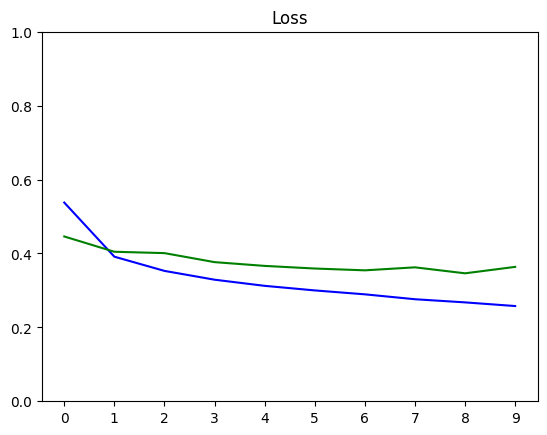

In [25]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

In [26]:
#This function displays a row of images with their predictions and true labels.
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)]

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

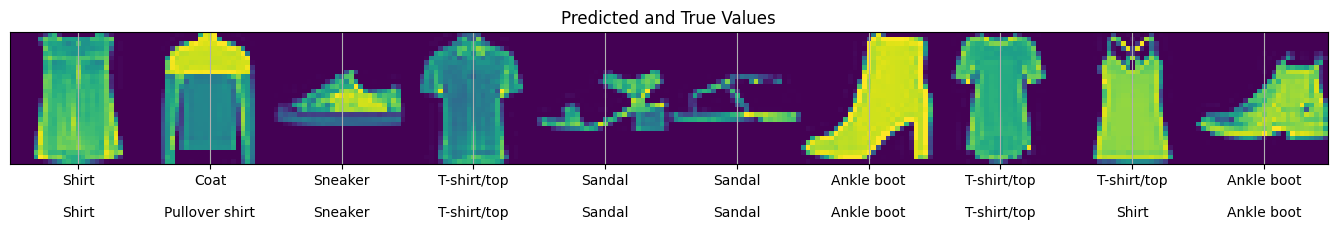

In [27]:
#You make predictions on the test dataset and plot the images with their true and predicted values.
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)